In [1]:
# imports 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
path_base = os.getcwd().split('Dragonfly44_SFH')[0] # gross, but works
path_data = path_base+ "Dragonfly44_SFH/data/"

from figure_style import *

In [2]:
obs_file = path_data+"Dragonfly44/obs_phot_specKCWI_sigma110.h5"

phot_file = path_data+"Dragonfly44/photometry.txt"

specKCWI_file_unsmoothed = path_data+"Dragonfly44/Villaume2022_KCWI/df44_optimal_unsmoothed_new_bad_pix_interp.dat"
specKCWI_file_smoothed = path_data+"Dragonfly44/Villaume2022_KCWI/df44_optimal_cl_avg_110kms_new_bad_pix_interp_fixb.dat"

lines_file = path_data+"linelists/lines.dat"

path_figures = 'figures/'
if not os.path.exists( path_figures ): os.mkdir( path_figures )

In [3]:
from Dragonfly44_SFH.utils.prospect_io import read_input

obs = read_input( obs_file )
zobs = obs['Redshift']

specnorm = 1e-8 # see notebook build_obs_dictionary_phot_specKCWI.ipynb

x,y,ey,_,_ = np.loadtxt(specKCWI_file_unsmoothed, unpack=True)
obs_unsmoothed = dict( wavelength=x, spectrum=y, unc=ey, specnorm=specnorm )

x,y,ey,_,_ = np.loadtxt(specKCWI_file_smoothed, unpack=True)
obs_smooth = dict( wavelength=x, spectrum=y, unc=ey, sigma_smooth=100, smoothtype='vel', specnorm=specnorm)


In [4]:
lines = np.genfromtxt( lines_file, delimiter=',',  dtype=[int,float,float,'<U10'] )

# plot observations

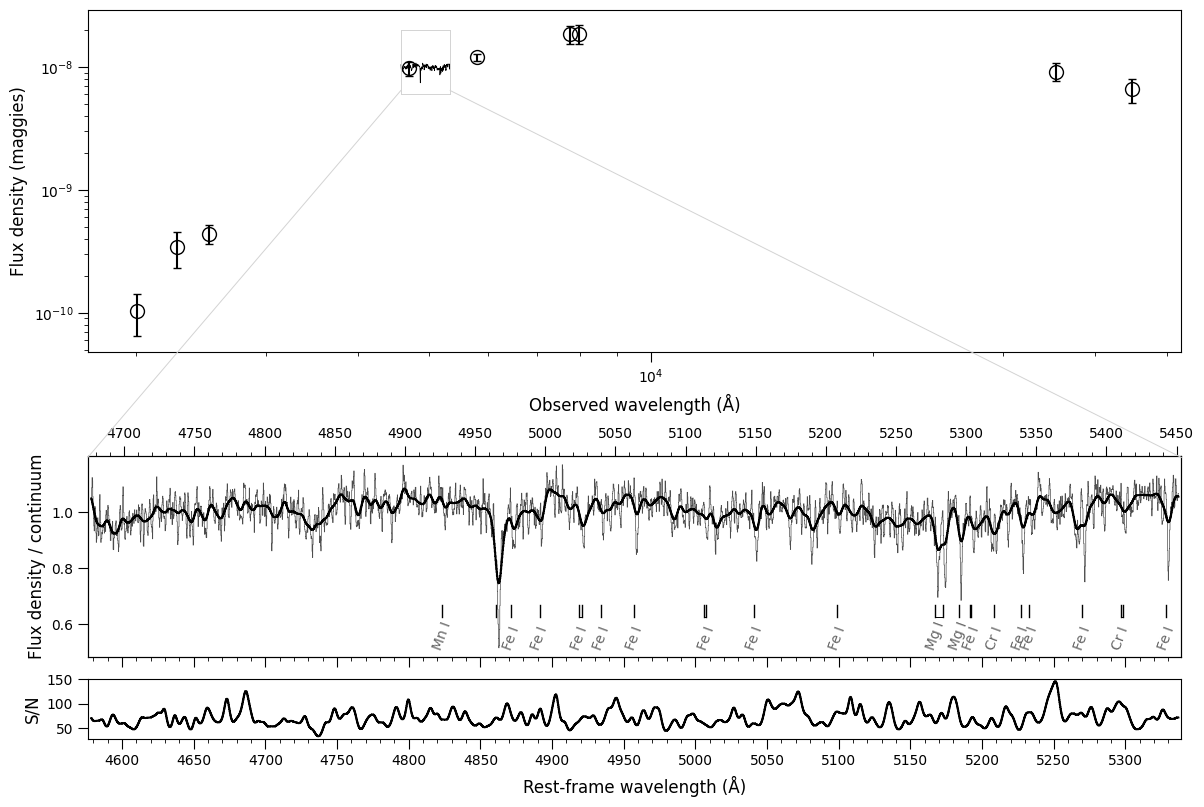

In [5]:
#
fs = 12
fig, axs = plt.subplots(2+1+1,1,figsize=(fig_width_two,0.5*textheight), gridspec_kw={"height_ratios":[1.7,0.3,1,0.3]}, sharex=False)
ax1, _, ax2, ax2b = axs.flatten()
axs[1].axis('off')

if True: # SED 
    x,y,ey = [ np.copy( obs[key] ) for key in ['phot_wave','maggies','maggies_unc']]
    ax1.errorbar( x, y, yerr=ey, marker='o', mfc='None',mec='k', color='k', capsize=3, fmt=' ', ms=10)
    
    ax1.set( xscale='log', yscale='log' )
    ax1.set_ylabel('Flux density (maggies)', fontsize=fs)
    
    ax1.tick_params(direction='out', length=7, which='major')
    ax1.tick_params(direction='out', length=3, which='minor')

if True: # spectrum 
    
    params_unsmooth = dict( color='0.3', lw=0.5, label="Unsmoothed spectrum" )
    params_smooth = dict( color='k', lw=1.5, label="Smoothed spectrum" )
    
    x,y,ey = [ np.copy( obs_unsmoothed[key] ) for key in ['wavelength','spectrum','unc'] ]
    x /= (1.+zobs)
    l1, = ax2.step( x, y, where='post', **params_unsmooth )

    x,y,ey = [ np.copy( obs_smooth[key] ) for key in ['wavelength','spectrum','unc'] ]
    x /= (1.+zobs)

    l2, = ax2.step( x, y, where='post', **params_smooth )
    ax1.step( x, y*1e-8, where='post', color='k', lw=0.5 )

    ax2b.step( x, (y/ey), where='post', **params_smooth)

    ax2.set_xlim( 4576, 5339 )
    xlim = ax2.get_xlim()
    xlim_rf = np.array(xlim)*(1+zobs)
    ax2t = ax2.twiny()
    ax2t.set_xlim( xlim_rf )
    ax2b.set_xlim( xlim )

    ax2b.set_xlabel(u"Rest-frame wavelength (\u00c5)", labelpad=6, fontsize=fs)    
    ax2t.set_xlabel(u"Observed wavelength (\u00c5)", labelpad=12, fontsize=fs)    
    ax2b.set_ylabel(u'S/N', fontsize=fs)
    #ax2.set_ylabel(r'$\nu f_\nu$', fontsize=fs) 
    ax2.set_ylabel(r'Flux density / continuum', fontsize=fs) 
    
    for ax in [ax2,ax2t,ax2b]:
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
        ax.tick_params(direction='out', length=7, which='major')
        ax.tick_params(direction='out', length=3, which='minor')
    
    ax2.set_xticklabels([])
    
    #ax2.legend( [l1,l2], [l1.get_label(),l2.get_label()], loc=3,  )
    
if True: # labels    
    ylim = ax2.get_ylim()
    dyline = 0.06
    #yy, yl = 0.15*np.diff( ylim) + ylim[0], 0.05 # line below label
    yy, yl = 0.04*np.diff( ylim) + ylim[0], 0.2  # line above label
    xline_last = np.nan
    
    yl_coo = ( yl ) * np.diff( ylim ) + ylim[0]
    
    for lset in lines:
        ispair, xline, _, labelline = lset
        
        color= ['k','r','c','gold'][ ispair ]
        
        ax2.axvline( xline, ymin=yl, ymax=yl+dyline, color='k', lw=1) 
    
        #xx = ( xlim[1]-lset[1] )/( xlim[1]-xlim[0] )
        #ax2.annotate( lset[3], xy=(0,0), xytext=( xx,0.14 ), xycoords='axes fraction', color='0.4', rotation=70, fontsize=10)   
        
        if ispair == 2:
            xline_last = xline
        elif ispair == 0:
            ax2.plot( [ xline_last, xline ], [ yl_coo,yl_coo ], color='k', lw=0.7)
            
        if ispair < 2:
            ax2.text( xline, yy, labelline, color='0.4', rotation=70, fontsize=10, ha='center') 
    
if True: # box
    x1,x2 = ax2.get_xlim()
    y1,y2 = 6e-9, 2e-8
    box_params = dict( color='lightgrey', lw=0.7 )
    ax1.plot( [x1,x2],[y1,y1], **box_params )
    ax1.plot( [x1,x2],[y2,y2], **box_params )
    ax1.plot( [x1,x1],[y1,y2], **box_params )
    ax1.plot( [x2,x2],[y1,y2], **box_params )
    
    from matplotlib.lines import Line2D
    transFigure = fig.transFigure.inverted()
    y3 = ax2.get_ylim()[1]
    coo11 = transFigure.transform( ax1.transData.transform( [x1, y1] ))
    coo21 = transFigure.transform( ax2.transData.transform( [x1, y3] ))
    l1 = Line2D( (coo11[0],coo21[0]), (coo11[1],coo21[1]), transform=fig.transFigure, **box_params )
    coo12 = transFigure.transform( ax1.transData.transform( [x2, y1] ))
    coo22 = transFigure.transform( ax2.transData.transform( [x2, y3] ))    
    l2 = Line2D( (coo12[0],coo22[0]), (coo12[1],coo22[1]), transform=fig.transFigure, **box_params )
    fig.lines = l1, l2

fig.subplots_adjust( hspace=0.13)
# plt.savefig( path_fig+"observations.png", **saveparams)
plt.show()

# generate three simple models to show in comparison to observations

In [5]:
from Dragonfly44_SFH.utils.build_sps_model import build_model_sps, build_sps_sps

sps = build_sps_sps()
model = build_model_sps( zobs )

In [6]:
obs_mock = dict( wavelength=None, spectrum=None, unc=None, mask=None, filters=None, maggies=None )
    
wave = sps.wavelengths * (1.+zobs )    

In [7]:
model.theta_labels()

['mass', 'logzsol', 'dust2', 'tage']

In [8]:
thetas1 = dict( mass=4e8, logzsol=-1.3, dust2=0.01, tage=12 )
thetas2 = dict( mass=4e8, logzsol=-1.3, dust2=0.3, tage=12 )
thetas3 = dict( mass=4e8, logzsol=-2, dust2=0.01, tage=12 )

In [9]:
theta1 = [ thetas1[k] for k in model.free_params ]
sed1,  _, _ = model.predict( theta1, obs=obs_mock, sps=sps)
spec1, _, _ = model.predict( theta1, obs=obs,  sps=sps)

theta2 = [ thetas2[k] for k in model.free_params ]
sed2,  _, _ = model.predict( theta2, obs=obs_mock, sps=sps)
spec2, _, _ = model.predict( theta2, obs=obs,  sps=sps)

theta3 = [ thetas3[k] for k in model.free_params ]
sed3,  _, _ = model.predict( theta3, obs=obs_mock, sps=sps)
spec3, _, _ = model.predict( theta3, obs=obs,  sps=sps)

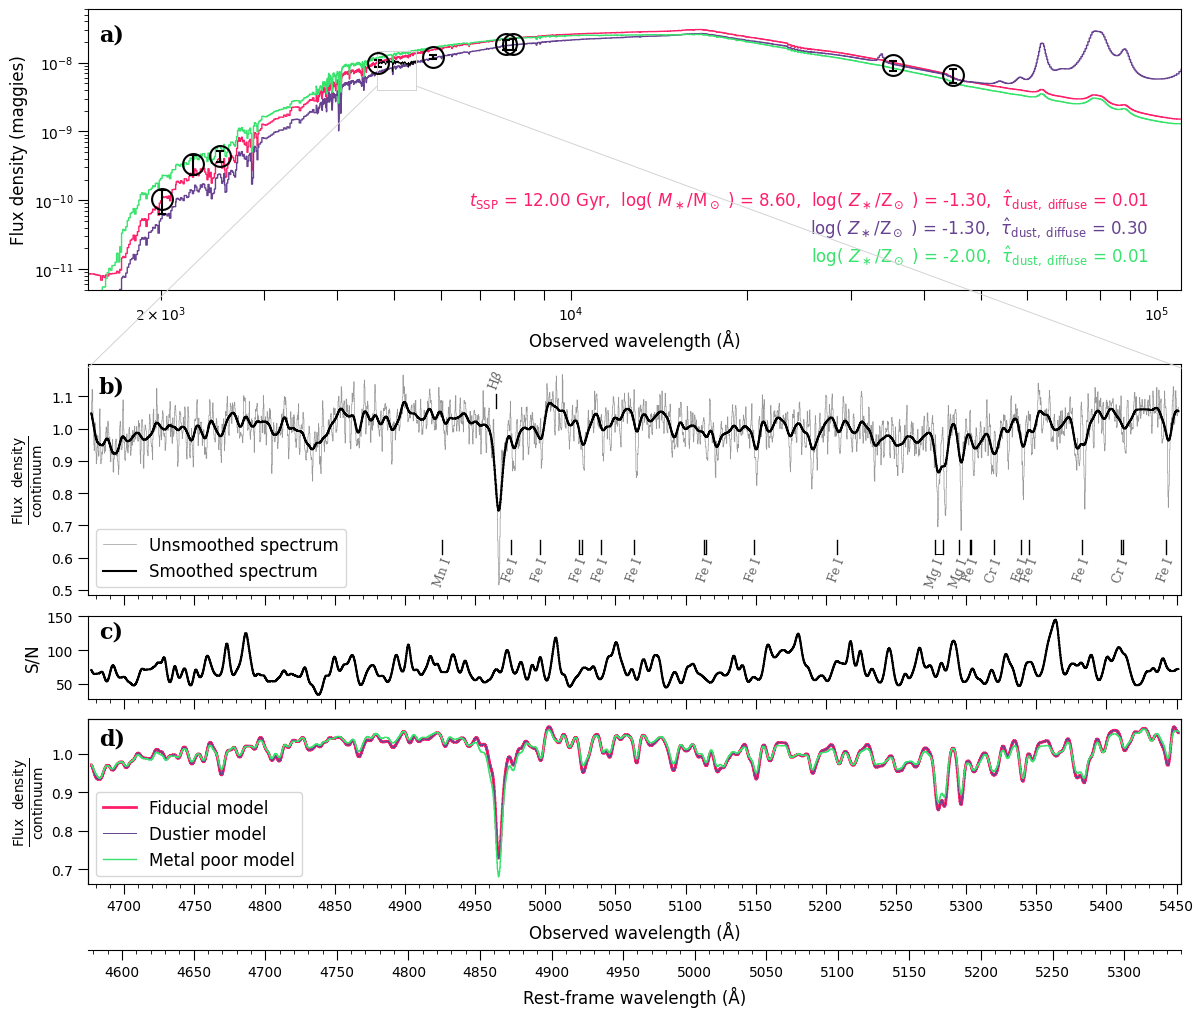

In [10]:
#
fs = 12
fig, axs = plt.subplots(2+1+1+1,1,figsize=(fig_width_two,0.6*textheight), gridspec_kw={"height_ratios":[1.7,0.2,1.4,0.5,1]}, sharex=False)
ax1, _, ax2, ax2b, ax2c = axs.flatten()
axs[1].axis('off')

if True: # SED 
    x,y,ey = [ np.copy( obs[key] ) for key in ['phot_wave','maggies','maggies_unc']]
    ax1.errorbar( x, y, yerr=ey, marker='o', mfc='None',mec='k', color='k', capsize=3, fmt=' ', ms=15, mew=1.5)
    
    ax1.set( xscale='log', yscale='log', xlim=(1.5e3, 1.1e5), ylim=(5e-12,6e-8) )
    ax1.set_ylabel('Flux density (maggies)', fontsize=fs)
    
    ax1.tick_params(direction='out', length=7, which='major')
    ax1.tick_params(direction='out', length=3, which='minor')
    ax1.set_xlabel(u"Observed wavelength (\u00c5)", fontsize=fs)    

if True: # spectrum 
    
    params_unsmooth = dict( color='0.6', lw=0.5, label="Unsmoothed spectrum" )
    params_smooth = dict( color='k', lw=1.5, label="Smoothed spectrum" )
    
    x,y,ey = [ np.copy( obs_unsmoothed[key] ) for key in ['wavelength','spectrum','unc'] ]
#     x /= (1.+zobs)
    l1, = ax2.step( x, y, where='post', **params_unsmooth )

    x,y,ey = [ np.copy( obs_smooth[key] ) for key in ['wavelength','spectrum','unc'] ]
#     x /= (1.+zobs)

    l2, = ax2.step( x, y, where='post', **params_smooth )
    ax1.step( x, y*1e-8, where='post', color='k', lw=0.5 )

    ax2b.step( x, (y/ey), where='post', **params_smooth)

    xlim_rf = np.array([4576, 5339])
    xlim_of = xlim_rf * (1.+zobs)
    ax2.set_xlim( xlim_of )
    ax2b.set_xlim( xlim_of )
    ax2c.set_xlim( xlim_of )
    
    ax2c.set_xlabel( u"Observed wavelength (\u00c5)", labelpad=6, fontsize=fs)    
    ax2b.set_ylabel( 'S/N', fontsize=fs)
    ax2.set_ylabel( r"$\frac{\mathrm{Flux~~density}}{\mathrm{continuum}}$", fontsize=fs+2) 
    ax2c.set_ylabel( ax2.get_ylabel(), fontsize=fs+2) 
    
    ax2t = ax2c.twiny()
    ax2t.set_xlim( xlim_of )
    xticks_major = np.arange( 4600, 5350, 50)
    xticks_minor = np.arange( 4580, 5350, 10)
    ax2t.set_xticks( xticks_major*(1.+zobs), )
    ax2t.set_xticks( xticks_minor*(1.+zobs), minor=True )
    ax2t.set_xticklabels( xticks_major )
    ax2t.xaxis.set_ticks_position("bottom")
    ax2t.xaxis.set_label_position("bottom")
    ax2t.tick_params(direction='out', length=7, which='major')
    ax2t.tick_params(direction='out', length=3, which='minor')
    ax2t.spines["bottom"].set_position(("axes", -0.4))
    ax2t.set_xlabel(u"Rest-frame wavelength (\u00c5)", labelpad=5, fontsize=fs)      
    
    for ax in [ax2,ax2b,ax2c]:
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
        ax.tick_params(direction='out', length=7, which='major')
        ax.tick_params(direction='out', length=3, which='minor')
    
    ax2.set_xticklabels([])
    ax2b.set_xticklabels([])
    
    ax2.legend( [l1,l2], [l1.get_label(),l2.get_label()], loc=3,  ) 
    
if True: # line labels 
    ylim = ax2.get_ylim()
    dyline = 0.06
    #yy, yl, va = 0.15*np.diff( ylim) + ylim[0], 0.05, 'bottom' # line below label
    yy, yl, va = 0.17*np.diff( ylim) + ylim[0], 0.18, 'top'  # line above label
    xline_last = np.nan
    
    yl_coo = ( yl ) * np.diff( ylim ) + ylim[0]
    
    for lset in lines:
        ispair, xline, _, labelline = lset
        xline *= (1.+zobs)
        
        if ispair != 3: # ie not Hbeta
        
            ax2.axvline( xline, ymin=yl, ymax=yl+dyline, color='k', lw=1) 
            if ispair == 2:
                xline_last = xline
            elif ispair == 0:
                ax2.plot( [ xline_last, xline ], [ yl_coo,yl_coo ], color='k', lw=0.7)

            if ispair < 2:
                ax2.text( xline, yy, labelline, color='0.4', rotation=70, fontsize=9, ha='center', va=va, family='serif')     
                
        else: # Hbeta 
            
            ax2.axvline( xline, ymin=0.87-dyline, ymax=0.87, color='k', lw=1) 
            ax2.text( xline, 0.88*np.diff( ylim) + ylim[0], labelline, color='0.4', rotation=70, fontsize=9, ha='center', va='bottom', family='serif')

if True: # box
    x1,x2 = ax2.get_xlim()
    y1,y2 = 4e-9, 1.5e-8
    box_params = dict( color='lightgrey', lw=0.7 )
    ax1.plot( [x1,x2],[y1,y1], **box_params )
    ax1.plot( [x1,x2],[y2,y2], **box_params )
    ax1.plot( [x1,x1],[y1,y2], **box_params )
    ax1.plot( [x2,x2],[y1,y2], **box_params )
    
    from matplotlib.lines import Line2D
    transFigure = fig.transFigure.inverted()
    y3 = ax2.get_ylim()[1]
    coo11 = transFigure.transform( ax1.transData.transform( [x1, y1] ))
    coo21 = transFigure.transform( ax2.transData.transform( [x1, y3] ))
    l1 = Line2D( (coo11[0],coo21[0]), (coo11[1],coo21[1]), transform=fig.transFigure, **box_params )
    coo12 = transFigure.transform( ax1.transData.transform( [x2, y1] ))
    coo22 = transFigure.transform( ax2.transData.transform( [x2, y3] ))    
    l2 = Line2D( (coo12[0],coo22[0]), (coo12[1],coo22[1]), transform=fig.transFigure, **box_params )
    fig.lines = l1, l2

if True: # models
    
    col1, col2, col3 = '#fe1f69','#674290','#bbbc5f'
    col3 = '#37E36C'
    for (spec,sed,col, lw,label) in [ [spec1,sed1,col1,2,"Fiducial model"], 
                                [spec2,sed2,col2,0.7,'Dustier model'], 
                                [spec3,sed3,col3,1,"Metal poor model"],
#                             [spec4,sed4,'gold'],
                           ]:
        ax1.step( wave, sed, color=col, lw=1., where='post', zorder=0 )
        ax2c.step( obs['wavelength'], spec*1e8, color=col, lw=lw, where='post', label=label )
           
    fmt = "{{0:{0}}}".format(".2f").format 
    label_params = [r"$t_\mathrm{SSP}$",\
                    r"$\log(~M_\ast/\mathrm{M}_\odot~)$",\
                    r"$\log(~Z_\ast/\mathrm{Z}_\odot~)$", \
                    r"$\hat{\tau}_\mathrm{dust,~diffuse}$"]
    label1 = "{0} = {4} Gyr,  {1} = {5},  {2} = {6},  {3} = {7}".format( *label_params, 
                                                                 fmt(theta1[3]), fmt(np.log10(theta1[0])), fmt(theta1[1]), fmt(theta1[2]) )
    ax1.annotate( label1, xy=(0,0), xytext=(0.97,0.3), ha='right', xycoords='axes fraction', fontsize=12, color=col1)
    label2 = "{2} = {6},  {3} = {7}".format( *label_params, 
                                                                 fmt(theta2[3]), fmt(np.log10(theta2[0])), fmt(theta2[1]), fmt(theta2[2]) )
    ax1.annotate( label2, xy=(0,0), xytext=(0.97,0.2), ha='right', xycoords='axes fraction', fontsize=12, color=col2)
    label2 = "{2} = {6},  {3} = {7}".format( *label_params, 
                                                                 fmt(theta3[3]), fmt(np.log10(theta3[0])), fmt(theta3[1]), fmt(theta3[2]) )
    ax1.annotate( label2, xy=(0,0), xytext=(0.97,0.1), ha='right', xycoords='axes fraction', fontsize=12, color=col3)

    ax2c.legend(loc=3)
if True: # panel labels
    ann_params = dict( xy=(0,0), xytext=(0.01,0.95),xycoords="axes fraction", ha="left", va="top", fontsize=16, family="serif", weight="bold" )
    ax1.annotate("a)", **ann_params)
    ax2.annotate("b)", **ann_params)
    ax2b.annotate("c)", **ann_params)
    ax2c.annotate("d)", **ann_params)
    
if True: # plot adjustments 
    
    xlim, xticks, xticks_m = ax1.get_xlim(), ax1.get_xticks(), ax1.get_xticks(minor=True)
    xticks = np.sort( np.append( ax1.get_xticks(), ax1.get_xticks(minor=True) ) )
    xticks = xticks[ (xlim[0]<=xticks) & (xticks<xlim[-1])]
    ax1.set_xticks( xticks )
    # [ 2.e3,  3.,  4.,  5.,  6.,  7.,  8.,  9., 1.e4, 2, 3, 4, 5, 6, 7]
    xticklabels = [r"$2\times10^3$", "", "", "", "", "", "", "", r"$10^4$", "", "", "", "", "", "", "", "",r"$10^5$",  ]
    ax1.set_xticklabels( xticklabels )     
    
fig.subplots_adjust( hspace=0.13)
plt.savefig( path_figures+"fig1.pdf", **saveparams )
plt.show()